In [19]:
!pip list


Package                      Version
---------------------------- -----------
absl-py                      2.2.2
aiohappyeyeballs             2.4.4
aiohttp                      3.10.11
aiosignal                    1.3.1
asttokens                    2.0.5
astunparse                   1.6.3
async-timeout                5.0.1
attrs                        25.3.0
backcall                     0.2.0
cachetools                   5.5.2
certifi                      2025.4.26
charset-normalizer           3.4.2
colorama                     0.4.6
comm                         0.2.1
contourpy                    1.1.1
cycler                       0.12.1
datasets                     3.1.0
debugpy                      1.6.7
decorator                    5.1.1
dill                         0.3.8
executing                    0.8.3
filelock                     3.16.1
flatbuffers                  25.2.10
fonttools                    4.57.0
frozenlist                   1.5.0
fsspec                       2024.9

# Kiểm tra môi trường

In [5]:
import tensorflow as tf

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
import tensorflow as tf
print("TensorFlow CUDA built with: ", tf.sysconfig.get_build_info()['cuda_version'])
print("GPU: ", tf.config.list_physical_devices('GPU'))


TensorFlow CUDA built with:  64_112
GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load Data and Preprocess

## Load data

In [7]:
from datasets import load_dataset, DatasetDict

E:\Anaconda\envs\ImageClassification_testing\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
dataset_url = 'uoft-cs/cifar10'
my_dataset = load_dataset(dataset_url)


In [13]:
# my_dataset['train'][10]
print(my_dataset['train'].features)

{'img': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}


In [15]:
# Lọc chỉ giữ label 0 và 1 từ tập 'train'
filtered_train = my_dataset['train'].filter(lambda example: example['label'] in [0, 1])

# Tách filtered_train thành train + validation (VD: 70% train, 30% validation)
split = filtered_train.train_test_split(test_size=0.3, seed=42)

# Lọc test cũng chỉ giữ label 0 và 1
filtered_test = my_dataset['test'].filter(lambda example: example['label'] in [0, 1])

# Tạo lại DatasetDict hoàn chỉnh
binary_dataset = DatasetDict({
    'train': split['train'],
    'validation': split['test'],
    'test': filtered_test
})

### Test binary dataset

In [17]:
#Test binary dataset

print(binary_dataset['train'].shape)
print(binary_dataset['validation'].shape)
print(binary_dataset['test'].shape)

# Kiểm tra các label có trong tập train
print("Train labels:", set(binary_dataset['train']['label']))

# Kiểm tra tập validation và test
print("Validation labels:", set(binary_dataset['validation']['label']))
print("Test labels:", set(binary_dataset['test']['label']))

(7000, 2)
(3000, 2)
(2000, 2)
Train labels: {0, 1}
Validation labels: {0, 1}
Test labels: {0, 1}


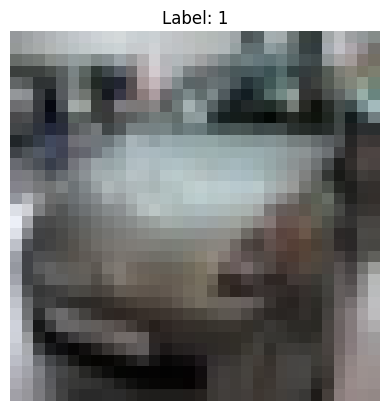

In [40]:
import matplotlib.pyplot as plt
from PIL import Image

# Lấy 1 mẫu đầu tiên trong tập train
sample = binary_dataset['train'][10]
image = sample['img']
label = sample['label']

# image = image.resize((320, 320), resample=Image.BILINEAR)

# Hiển thị ảnh
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [42]:
import numpy as np

image_np = np.array(image)

image_np.shape

(32, 32, 3)

## Chia tập Train - Val - Test

In [19]:
import numpy as np
import tensorflow as tf

# Hàm không cần trả về dict nữa nếu dùng trong generator
def convert_to_tf_dataset(hf_dataset, batch_size=32, shuffle=False):
    def gen():
        for example in hf_dataset:
            image = np.array(example['img']).astype(np.float32) / 255.0
            label = example['label']
            yield image, label  #Trả về tuple (img, label)

    # Định nghĩa cấu trúc output đúng
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [21]:

train_ds = convert_to_tf_dataset(binary_dataset['train'], batch_size=32, shuffle=True)
val_ds   = convert_to_tf_dataset(binary_dataset['validation'], batch_size=32)
test_ds  = convert_to_tf_dataset(binary_dataset['test'], batch_size=32)


### Test data train - val - test

In [99]:
print("Train: ",train_ds)
print("Validation: ",val_ds)
print("Test: ",test_ds)

Train:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Validation:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Test:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [81]:

train_iterator = train_ds.as_numpy_iterator()

In [83]:
train_batch = train_iterator.next()

In [101]:
train_batch[0].shape

(32, 32, 32, 3)

# Model

## Build Model

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [151]:
model = Sequential()

In [153]:
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))  # Phân loại nhị phân

In [155]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [157]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                      

## Training

In [128]:
logdir = 'logs'

In [130]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [159]:
hist = model.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks = [tensorboard_callback])

Epoch 1/100
219/219 [==============================] - 4s 16ms/step - loss: 0.4810 - accuracy: 0.8076 - val_loss: 6.1154 - val_accuracy: 0.5090
Epoch 2/100
219/219 [==============================] - 3s 15ms/step - loss: 0.2899 - accuracy: 0.8841 - val_loss: 0.4390 - val_accuracy: 0.8430
Epoch 3/100
219/219 [==============================] - 3s 14ms/step - loss: 0.2224 - accuracy: 0.9136 - val_loss: 0.1807 - val_accuracy: 0.9267
Epoch 4/100
219/219 [==============================] - 3s 14ms/step - loss: 0.1883 - accuracy: 0.9267 - val_loss: 0.1541 - val_accuracy: 0.9423
Epoch 5/100
219/219 [==============================] - 3s 14ms/step - loss: 0.1539 - accuracy: 0.9444 - val_loss: 0.1355 - val_accuracy: 0.9470
Epoch 6/100
219/219 [==============================] - 3s 14ms/step - loss: 0.1267 - accuracy: 0.9527 - val_loss: 0.1245 - val_accuracy: 0.9567
Epoch 7/100
219/219 [==============================] - 3s 14ms/step - loss: 0.1158 - accuracy: 0.9587 - val_loss: 0.2057 - val_accuracy:

## Plot Performance

<function matplotlib.pyplot.show(close=None, block=None)>

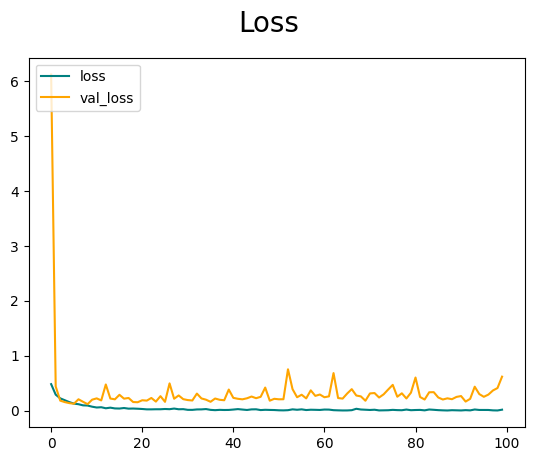

In [161]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

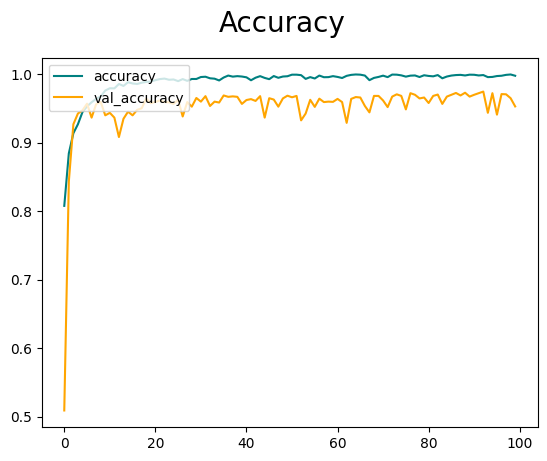

In [163]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show

# Save Model

In [ ]:
import os

model.save(os.path.join('modelSave','BinaryVehicleClassification.h5'))


# Testing

In [13]:
from tensorflow.keras.models import load_model
import os

loaded_model = load_model(os.path.join('modelSave','BinaryVehicleClassification.h5'))


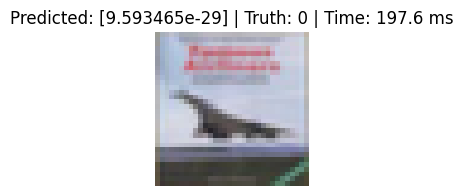

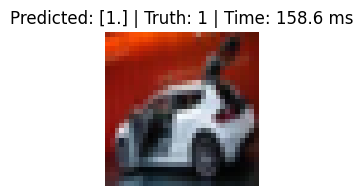

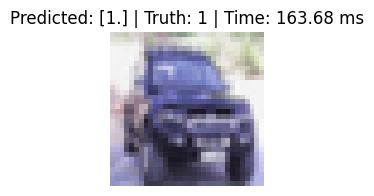

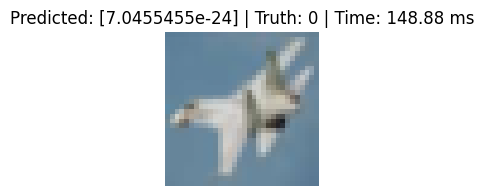

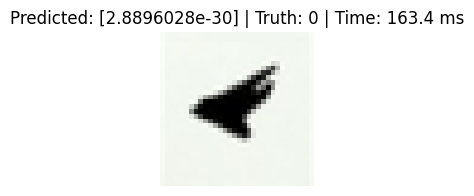

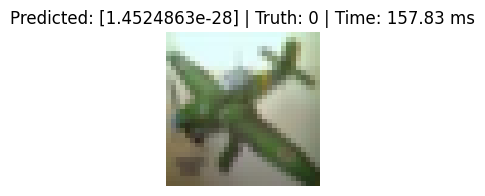

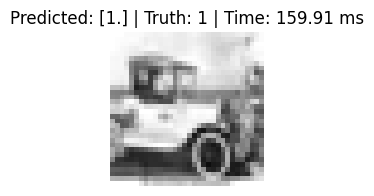

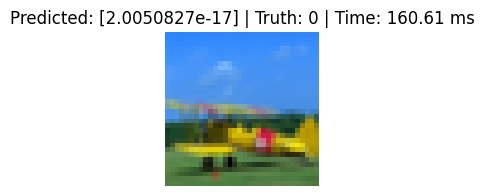

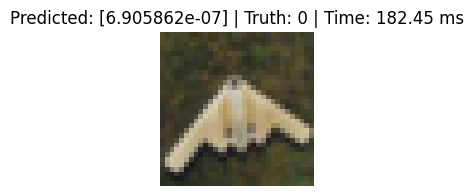

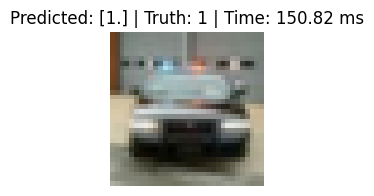

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Lấy 1 batch từ test_ds
for images, labels in test_ds.take(1):
    for i in range(10):  # Chỉ lấy 5 ảnh đầu
        img = tf.expand_dims(images[i], axis=0)  # Thêm batch dimension: (1, 32, 32, 3)

        start_t = time.perf_counter()
        pred = loaded_model.predict(img, verbose=0)
        end_t = time.perf_counter()

        infer_t = (end_t - start_t) * 1000  
        infer_t = round(infer_t, 2)  

        plt.figure(figsize=(2, 2))
        plt.imshow(images[i].numpy())
        plt.title(f"Predicted: {pred[0]} | Truth: {labels[i].numpy()} | Time: {infer_t} ms")
        plt.axis('off')
        plt.show()

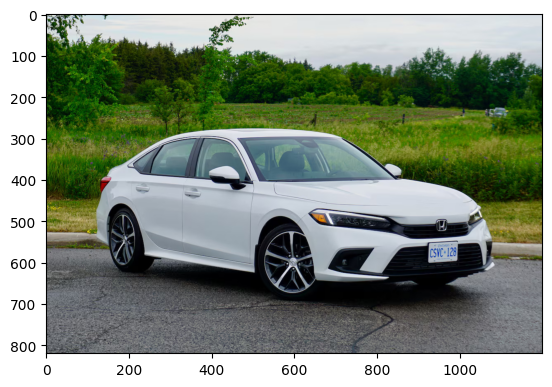

In [14]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
img = cv2.imread('.\\data_to_newTesting\\VehicleClassification\\car.jpg')
plt.imshow(cv2.cvtColor(img , cv2.COLOR_BGR2RGB))
plt.show()

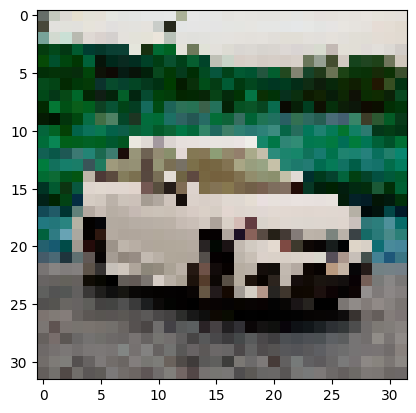

In [16]:
resize = tf.image.resize(img, (32,32))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [22]:
resize_np = resize.numpy().astype(int)
resize_np.shape

(32, 32, 3)

In [271]:
predict = loaded_model.predict(np.expand_dims(resize/255, 0))

if predict > 0.5:
    print("Car: ", predict)
else:
    print("Airplane: ", predict)

1/1 [==============================] - 0s 99ms/step
Car:  [[1.]]


# Full Testing

In [ ]:
from tensorflow.keras.models import load_model
import os

loaded_model = load_model(os.path.join('modelSave','BinaryVehicleClassification.h5'))

1/1 [==============================] - 0s 36ms/step
Car: [[1.]] | Time: 96.49 ms


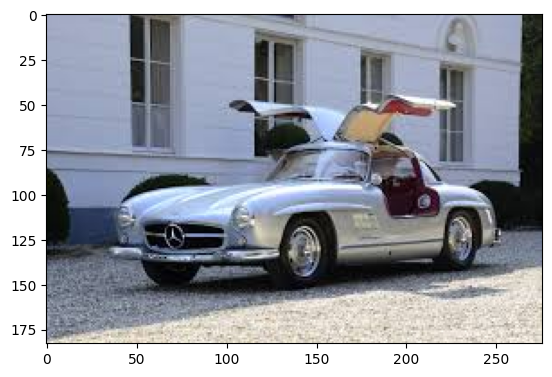

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time


img = cv2.imread('.\\data_to_newTesting\\VehicleClassification\\car2.jpg')

resize = tf.image.resize(img, (32,32))
# plt.imshow(resize.numpy().astype(int))
# plt.show()

start_t = time.perf_counter()
predict = loaded_model.predict(np.expand_dims(resize/255, 0))
end_t = time.perf_counter()

infer_t = (end_t - start_t) * 1000  
infer_t = round(infer_t, 2)  

if predict > 0.5:
    print(f"Car: {predict} | Time: {infer_t} ms", )
    plt.imshow(cv2.cvtColor(img , cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print(f"Airplane: {predict} | Time: {infer_t}", )
    plt.imshow(cv2.cvtColor(img , cv2.COLOR_BGR2RGB))
    plt.show()